In [2]:
import pandas as pd
import modules.preprocessing.sampling as sampling
import modules.preprocessing.scaling as scaling
import modules.constants as const

import numpy as np
import modules.training.LSTMmodels as LSTMmodels
import torch.nn as nn
import torch.optim as optim
import modules.training.training as training

import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import torch

import modules.utils as utils
import modules.plot_utils as plutils
import modules.plot_constants as pltconst
from modules.plot_constants import uzh_colors

from tqdm import tqdm

In [3]:
results_dir = const.tezos_results_dir + "Predictions/Simple Model/"

### Load All Data

In [3]:
# Input features
market_df = pd.read_csv(const.input_X_dir + "Market.csv")
network_df = pd.read_csv(const.input_X_dir + "NetworkActivity.csv")
social_df = pd.read_csv(const.input_X_dir + "SocialNetworks.csv")
supply_df = pd.read_csv(const.input_X_dir + "Supply.csv")
technical_df = pd.read_csv(const.input_X_dir + "TechnicalIndicators.csv")

# Target feature and dates
df_y = pd.read_csv(const.input_y_dir + "Target.csv")
dates_df = pd.read_csv(const.input_y_dir + "Dates.csv")

y = df_y.values
dates = dates_df.values.flatten()

all_dfs = [market_df, network_df, social_df, supply_df, technical_df]

data_names = ["market", "network", "social", "supply", "TI"]


### Chosen configuration Simple Model

In [4]:
TEST_SIZE = sampling.calculate_test_size_from_date(const.test_start_date)
WINDOW_SIZE = 30
STEP_SIZE = 1
OUTPUT_DIM = 1

mse_loss = nn.MSELoss()

N_EPOCHS = 100
N_HIDDEN = 128
LR = 0.001

BATCH_SIZE = 128
DO_SEGMENTATION = False

SHORTER_INDEX = 60


In [16]:
# pd.DataFrame(np.load(results_dir + "Predictions_with_segmentation.csv copy.npy", allow_pickle=True))
pd.read_csv(results_dir + "Results_with_segmentation copy.csv")

,number,market,network,social,supply,TI,MSE,RMSE,MAE,MAPE,MSE_short,RMSE_short,MAE_short,MAPE_short
0,1,0,0,0,0,1,63.4164,7.9634,7.7488,3.4044,13.8707,3.7243,3.6674,16.1661
1,3,0,0,0,1,1,73.8162,8.5916,8.4130,4.1194,21.2770,4.6127,4.5438,21.0507
2,5,0,0,1,0,1,61.0342,7.8124,7.6420,3.4384,16.9259,4.1141,4.0273,16.6062
3,7,0,0,1,1,1,67.8697,8.2383,8.0152,3.5652,15.4387,3.9292,3.8456,17.1001
4,9,0,1,0,0,1,70.5954,8.4021,8.1983,3.7289,17.0020,4.1234,4.0620,18.1397
5,11,0,1,0,1,1,74.7410,8.6453,8.4459,3.8438,18.9483,4.3530,4.2844,18.7041
6,13,0,1,1,0,1,66.4958,8.1545,7.9438,3.5514,14.8875,3.8584,3.7975,17.0598
7,15,0,1,1,1,1,73.1643,8.5536,8.3538,3.8570,18.3701,4.2860,4.2273,18.9636
8,16,1,0,0,0,0,59.7989,7.7330,7.5575,3.4383,14.6682,3.8299,3.7697,16.6995
9,17,1,0,0,0,1,59.2686,7.6986,7.4989,3.3790,13.4846,3.6721,3.6248,16.3435


## Without segmentation

In [27]:
all_results = []
all_predictions = []

for i in tqdm(range(1, 32)):
    # Choose which data combinations to exclude: dont include data set combinations if they do not include either market data or TI data
    if i < 16 and i % 2 == 0: continue

    X_data, dict_chosen = utils.get_data_from_combination_number(i, all_dfs, data_names=data_names)
    X_train, y_train, X_test, y_test, scaler = sampling.prepare_input_data(X_data, y, test_size=TEST_SIZE, window_size=WINDOW_SIZE, step_size=STEP_SIZE, do_segmentation=DO_SEGMENTATION)
    train_loader = sampling.make_data_loader(X_train, y_train, batch_size=BATCH_SIZE)

    model = LSTMmodels.LSTMSimple(input_size=X_train.shape[2], hidden_size=N_HIDDEN, output_size=OUTPUT_DIM)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Train the model
    model, _ = training.train_model(model, train_loader, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn = mse_loss)
    
    # Predict on the full test set and unscale the values
    predictions, _ = training.make_prediction(model, X_test, y_test, mse_loss)
    predictions_unsc = scaler.inverse_transform(predictions.reshape(-1,1))

    # Meaasure metrics for both test sets
    metrics1 = training.get_all_relevant_metrics(prediction=predictions_unsc, targets=y_test)
    metrics2 = training.get_all_relevant_metrics(prediction=predictions_unsc[:SHORTER_INDEX], targets=y_test[:SHORTER_INDEX])

    # Append the results of this data combination
    metrics2 = {key + "_short": value for key, value in metrics2.items()}
    
    all_results.append({**dict_chosen, **metrics1, **metrics2})
    all_predictions.append({**dict_chosen, **{"prediction": predictions_unsc.flatten()}})

    # Save the metrics results tables
    pd.DataFrame.from_dict(all_results).to_csv(results_dir + "Results_full_test_no_segmentation.csv", index=False)

    # Convert predictions to numpy format and save numpy file
    all_predictions_df = pd.DataFrame.from_dict(all_predictions)
    np.save(results_dir + "Predictions_full_test_no_segmentation.npy",all_predictions_df.values)

        

100%|██████████| 31/31 [53:38<00:00, 103.84s/it] 


In [31]:
predictions = np.load(results_dir + "Predictions_full_test_no_segmentation.npy", allow_pickle=True)
pred = pd.DataFrame(predictions)

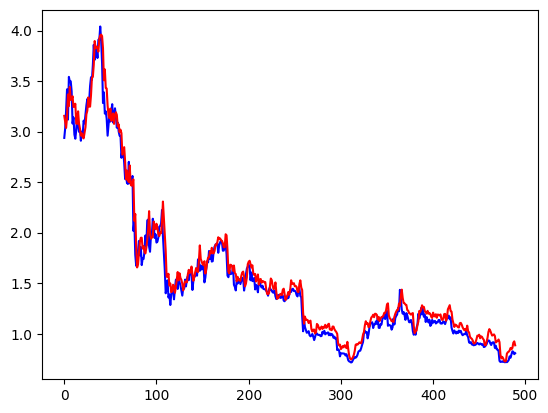

In [33]:
yp = pred.loc[0, 6]
y_tgt = y[-len(yp):]
plt.plot(range(len(y_tgt)), y_tgt, color="blue")
plt.plot(range(len(yp)), yp, color="red")


## With segmentation

In [18]:
DO_SEGMENTATION = True

dest_file_results = results_dir + "Results_with_segmentation.csv"
dest_file_predictions = results_dir + "Predictions_with_segmentation.npy"

In [19]:
all_results = []
all_predictions = []

for i in tqdm(range(1, 32)):
    if i <= 26: continue
    # Choose which data combinations to exclude: dont include data set combinations if they do not include either market data or TI data
    if i < 16 and i % 2 == 0: continue

    X_data, dict_chosen = utils.get_data_from_combination_number(i, all_dfs, data_names=data_names)
    X_train, y_train, X_test, y_test, scaler = sampling.prepare_input_data(X_data, y, test_size=TEST_SIZE, window_size=WINDOW_SIZE, step_size=STEP_SIZE, do_segmentation=DO_SEGMENTATION)
    train_loader = sampling.make_data_loader(X_train, y_train, batch_size=BATCH_SIZE)

    model = LSTMmodels.LSTMSimple(input_size=X_train.shape[2], hidden_size=N_HIDDEN, output_size=OUTPUT_DIM)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Train the model
    model, _ = training.train_model(model, train_loader, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn = mse_loss)
    
    # Predict on the full test set and unscale the values
    predictions, _ = training.make_prediction(model, X_test, y_test, mse_loss)
    predictions_unsc = scaler.inverse_transform(predictions.reshape(-1,1))

    # Meaasure metrics for both test sets
    metrics1 = training.get_all_relevant_metrics(prediction=predictions_unsc, targets=y_test)
    metrics2 = training.get_all_relevant_metrics(prediction=predictions_unsc[:SHORTER_INDEX], targets=y_test[:SHORTER_INDEX])

    # Append the results of this data combination
    metrics2 = {key + "_short": value for key, value in metrics2.items()}
    
    all_results.append({**dict_chosen, **metrics1, **metrics2})
    all_predictions.append({**dict_chosen, **{"prediction": predictions_unsc.flatten()}})

    # Save the metrics results tables
    pd.DataFrame.from_dict(all_results).to_csv(dest_file_results, index=False)

    # Convert predictions to numpy format and save numpy file
    all_predictions_df = pd.DataFrame.from_dict(all_predictions)
    np.save(dest_file_predictions,all_predictions_df.values)

        

100%|██████████| 31/31 [10:40<00:00, 20.65s/it]
